<a href="https://colab.research.google.com/github/SAIKRISHNA239/Pneumonia_detection/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import transforms
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, VGG19, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import os
import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers  # Added optimizers here
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [5]:
# dataset_path = './chest-xray'
dataset_path = '/content/drive/MyDrive/chest-xray'

In [6]:
data_dir = "/content/drive/MyDrive/chest-xray"
batch_size = 32
img_height, img_width = 224, 224

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f"{data_dir}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    f"{data_dir}/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    f"{data_dir}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5857 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 684 images belonging to 2 classes.


In [7]:
def create_model(base_model):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [8]:
base_models = [
    (ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), 'ResNet50'),
    (InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), 'InceptionV3'),
    (VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), 'VGG16'),
    (EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), 'EfficientNetB0')
]

for i, (base_model, model_name) in enumerate(base_models):
    print(f"Training model {model_name}")
    model = create_model(base_model)
    model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=2)

    # Prediction
    y_true = test_generator.classes
    y_pred = np.round(model.predict(test_generator)).astype(int).flatten()

    # Evaluation
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Model {model_name}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")


16705208/16705208 [==============================] - 0s 0us/step
Training model ResNet50
Epoch 1/5
184/184 - 1668s - loss: 0.1386 - accuracy: 0.9551 - val_loss: 53.0951 - val_accuracy: 0.5000 - 1668s/epoch - 9s/step
Epoch 2/5
184/184 - 81s - loss: 0.0587 - accuracy: 0.9771 - val_loss: 4.5884 - val_accuracy: 0.5000 - 81s/epoch - 438ms/step
Epoch 3/5
184/184 - 82s - loss: 0.0875 - accuracy: 0.9674 - val_loss: 0.9812 - val_accuracy: 0.4375 - 82s/epoch - 445ms/step
Epoch 4/5
184/184 - 80s - loss: 0.0884 - accuracy: 0.9706 - val_loss: 6.5949 - val_accuracy: 0.5000 - 80s/epoch - 433ms/step
Epoch 5/5
184/184 - 77s - loss: 0.0385 - accuracy: 0.9872 - val_loss: 1.6065 - val_accuracy: 0.5000 - 77s/epoch - 419ms/step
22/22 [==============================] - 235s 11s/step
Model ResNet50: Accuracy: 0.6301169590643275, Precision: 0.6295754026354319, Recall: 1.0, F1 Score: 0.7726864330637915

Training model InceptionV3
Epoch 1/5
184/184 - 119s - loss: 0.1171 - accuracy: 0.9589 - val_loss: 0.0767 - va

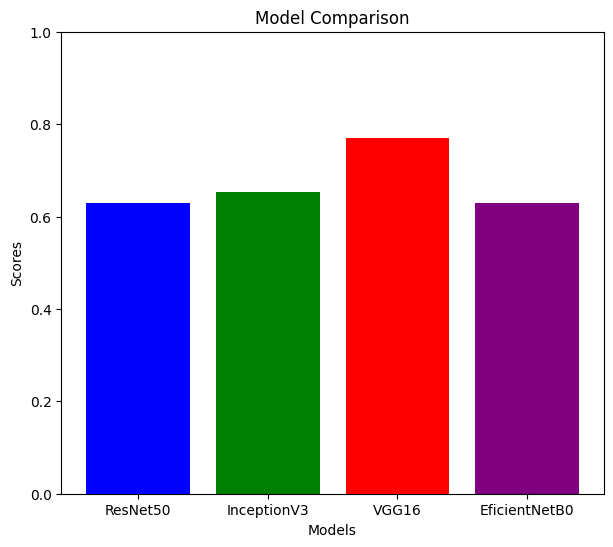

In [10]:
import matplotlib.pyplot as plt
model_names = ['ResNet50', 'InceptionV3', 'VGG16', 'EficientNetB0']
accuracy_scores = [ 0.63011,0.6535, 0.7690, 0.6286]
scores = accuracy_scores
plt.figure(figsize=(7, 6))
plt.bar(model_names, scores, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.0)
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.show()